In [3]:
from ensemble_lstm import AutoLSTM
from ensemble_cnn import AutoCNN
from ensemble_rf import AutoRF

In [40]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

from datetime import datetime

from scipy.signal import savgol_filter

from sklearn.metrics import r2_score, mean_squared_error

In [30]:
import warnings
warnings.filterwarnings('ignore')

In [6]:
tf.get_logger().setLevel('INFO')

seed_value= 42
tf.random.set_seed(seed_value)

lags = [24]*24
leads = range(1,24+1)

In [8]:
cnn_model = AutoCNN(data_name='data_1107.xlsx', target_name='SP500-EPS-Index', drop_cols=[])
cnn_model.run(use_target=True, lags=lags, leads=leads)
cnn_p, cnn_t = cnn_model.get_backtesting()

rf_model = AutoRF(data_name='data_1107.xlsx', target_name='SP500-EPS-Index', drop_cols=[])
rf_model.run(lags=lags, leads=leads)
rf_p, rf_t = rf_model.get_backtesting()

lstm_model = AutoLSTM(data_name='data_1107.xlsx', target_name='SP500-EPS-Index', drop_cols=[])
lstm_model.run(use_target=True, lags=lags, leads=leads)
lstm_p, lstm_t = lstm_model.get_backtesting()


In [11]:
result_list = []
true_list = []
cnt_list = []

for i in range(len(leads)):

    combined_df = pd.DataFrame({'SP500-EPS_CNN_Pred':cnn_p[i], 'SP500-EPS_LSTM_Pred':lstm_p[i], 'Period_RF_Pred':rf_p[i]})

    result = [(combined_df.iloc[0]['SP500-EPS_LSTM_Pred'] + combined_df.iloc[0]['SP500-EPS_CNN_Pred'])/2]
    cnt = 0

    for index in range(1, len(combined_df)):
        if combined_df.iloc[index]['Period_RF_Pred'] != combined_df.iloc[index-1]['Period_RF_Pred']:
            cnt += 1
        if combined_df.iloc[index]['Period_RF_Pred'] == 0:
            if (combined_df.iloc[index]['SP500-EPS_CNN_Pred'] > result[index-1]) and (combined_df.iloc[index]['SP500-EPS_LSTM_Pred'] > result[index-1]):
                    result.append(result[-1])
            elif (combined_df.iloc[index]['SP500-EPS_CNN_Pred'] < result[index-1]) and (combined_df.iloc[index]['SP500-EPS_LSTM_Pred'] < result[index-1]):
                    tmp = (combined_df.iloc[index]['SP500-EPS_LSTM_Pred'] + combined_df.iloc[index]['SP500-EPS_CNN_Pred'])/2
                    result.append(tmp)
            else:
                result.append(min(combined_df.iloc[index]['SP500-EPS_CNN_Pred'], combined_df.iloc[index]['SP500-EPS_LSTM_Pred']))
        else:
            if (combined_df.iloc[index]['SP500-EPS_CNN_Pred'] > result[index-1]) and (combined_df.iloc[index]['SP500-EPS_LSTM_Pred'] > result[index-1]):
                    tmp = (combined_df.iloc[index]['SP500-EPS_LSTM_Pred'] + combined_df.iloc[index]['SP500-EPS_CNN_Pred'])/2
                    result.append(tmp)
            elif (combined_df.iloc[index]['SP500-EPS_CNN_Pred'] < result[index-1]) and (combined_df.iloc[index]['SP500-EPS_LSTM_Pred'] < result[index-1]):
                    result.append(result[-1])
            else:
                result.append(max(combined_df.iloc[index]['SP500-EPS_CNN_Pred'], combined_df.iloc[index]['SP500-EPS_LSTM_Pred']))
    
    result_list.append(result)
    true_list.append(cnn_t[i])
    cnt_list.append(cnt)

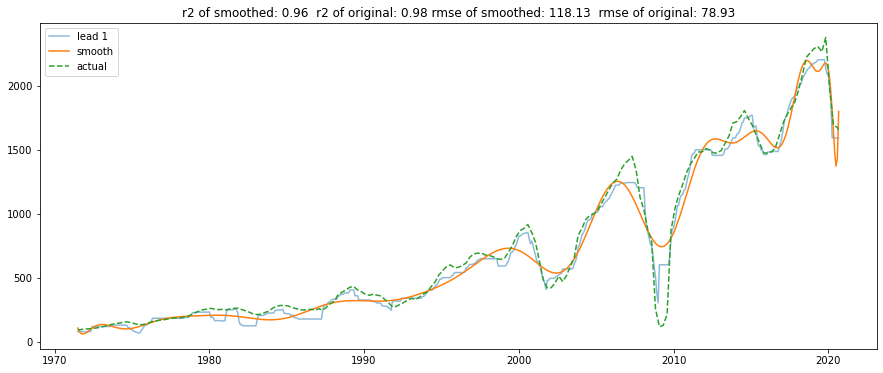

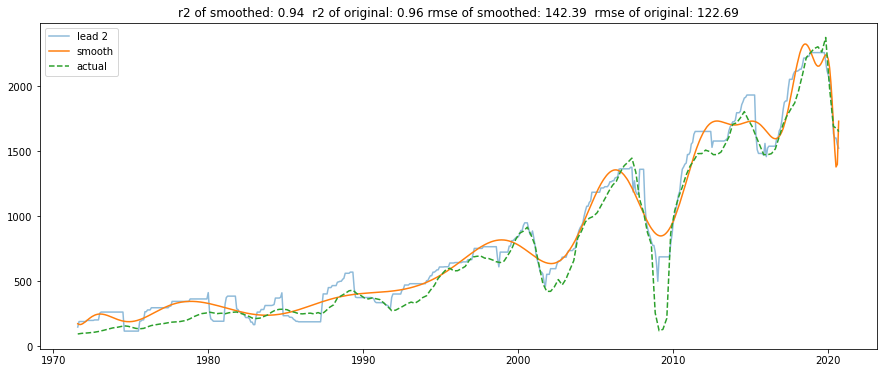

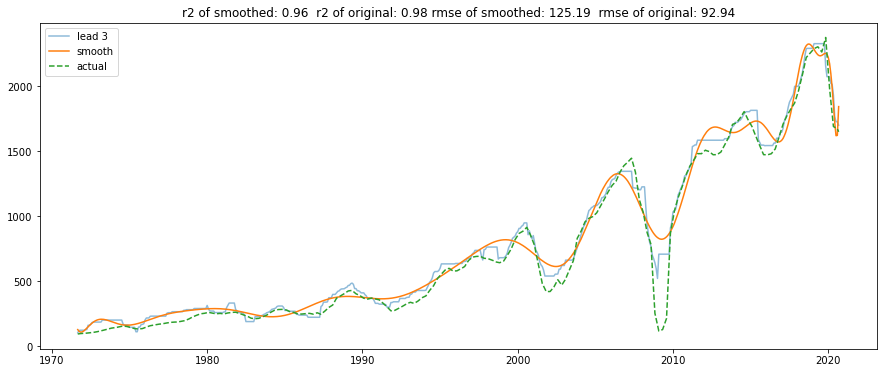

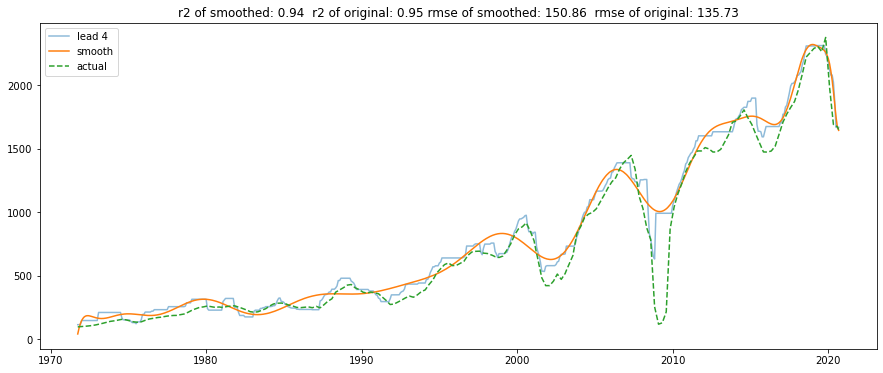

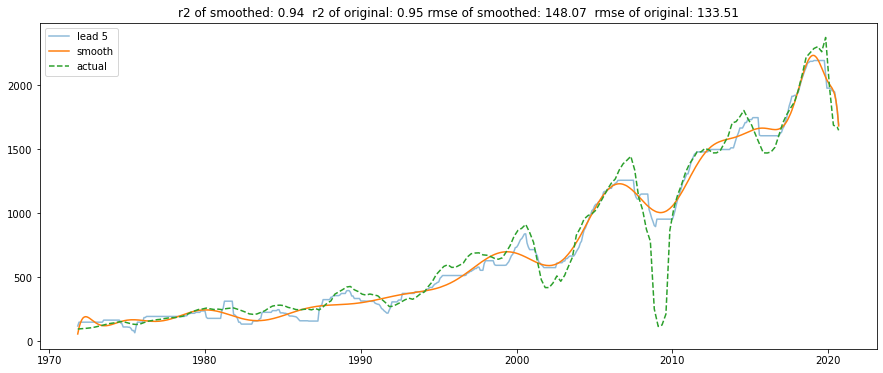

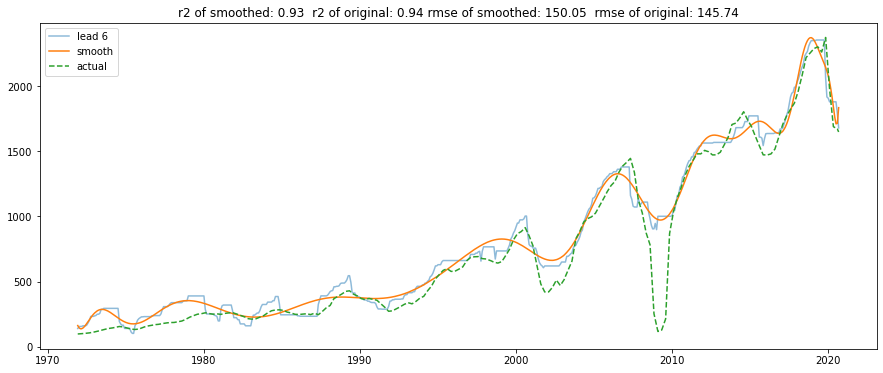

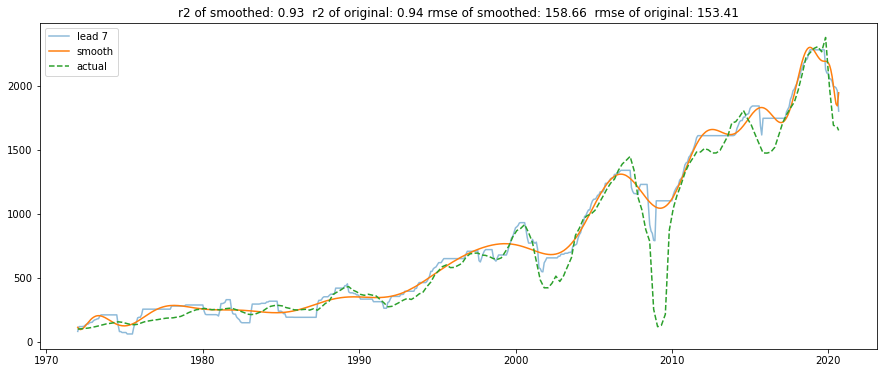

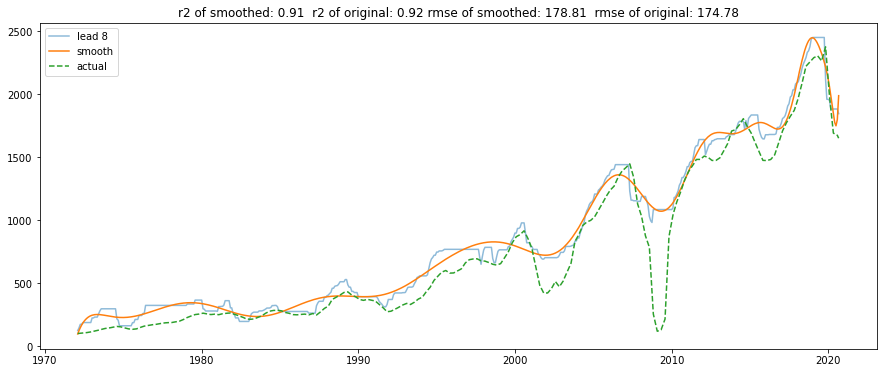

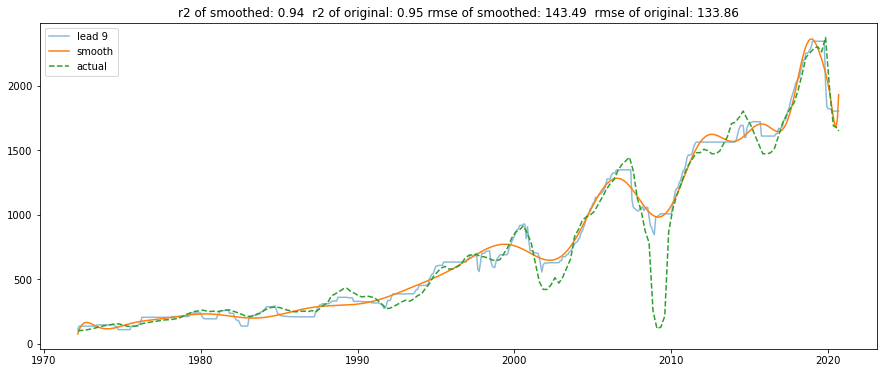

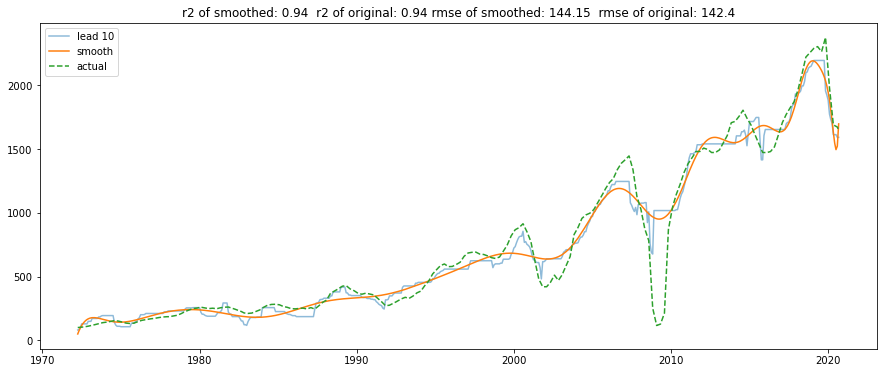

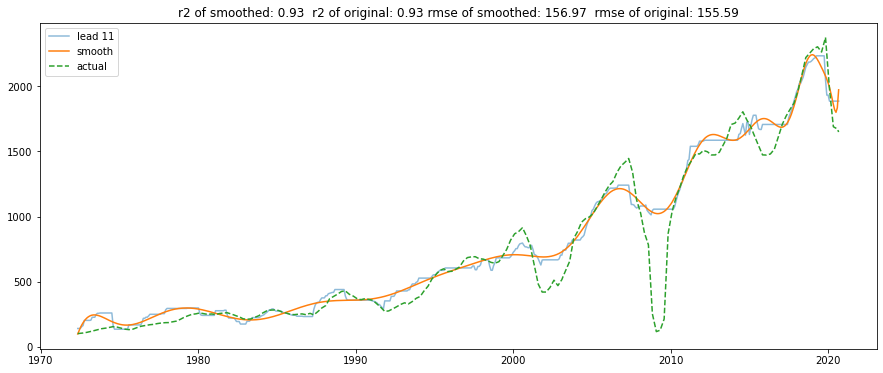

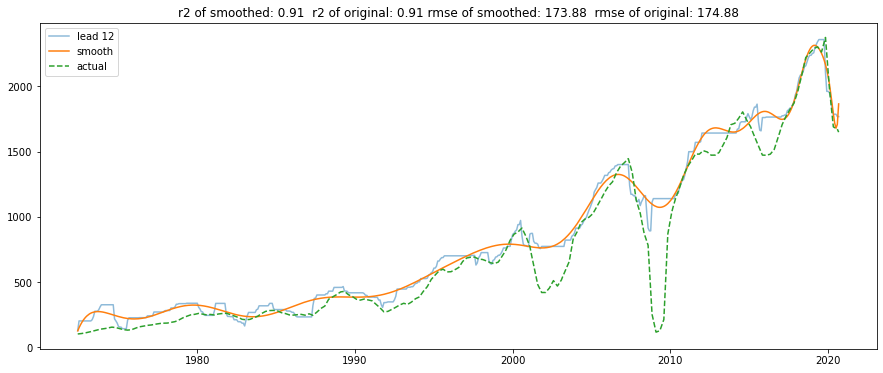

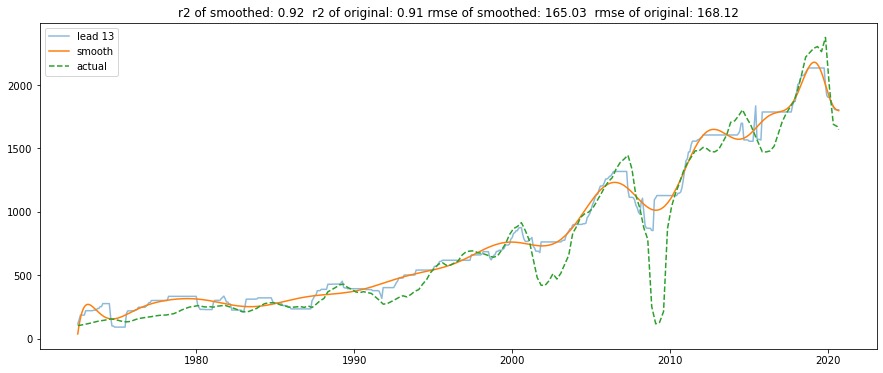

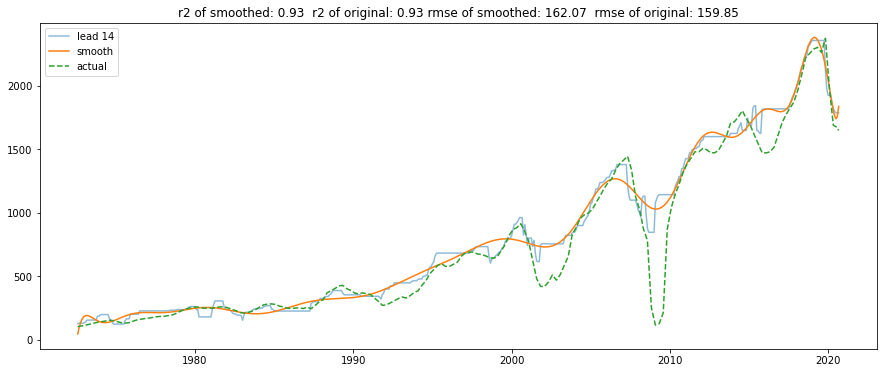

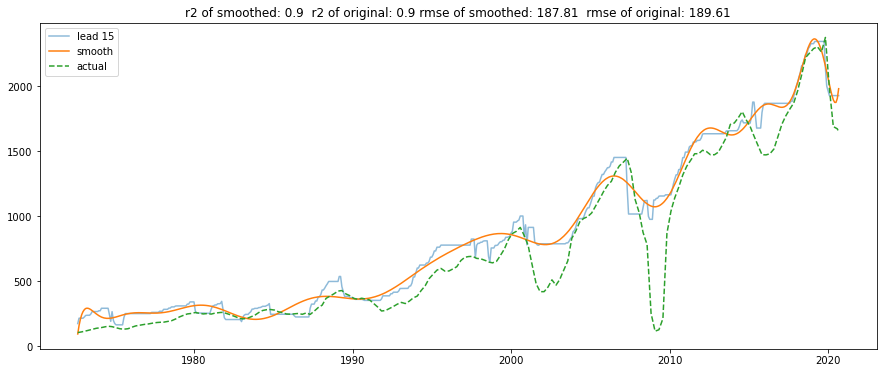

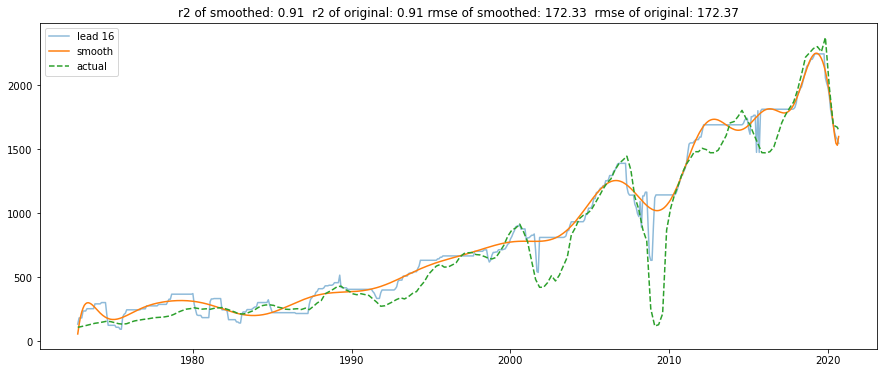

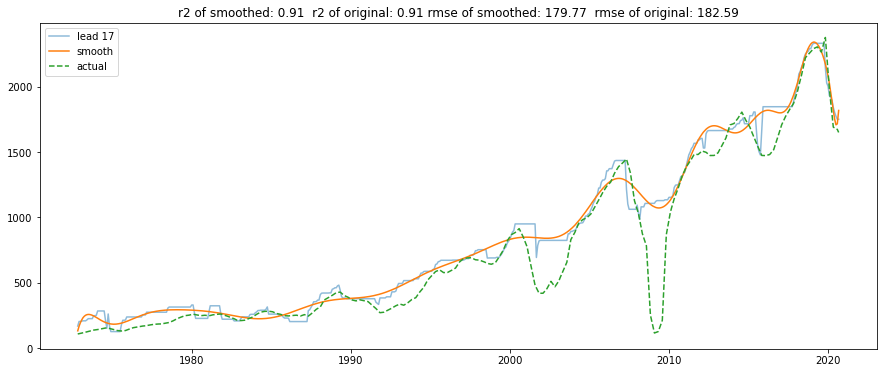

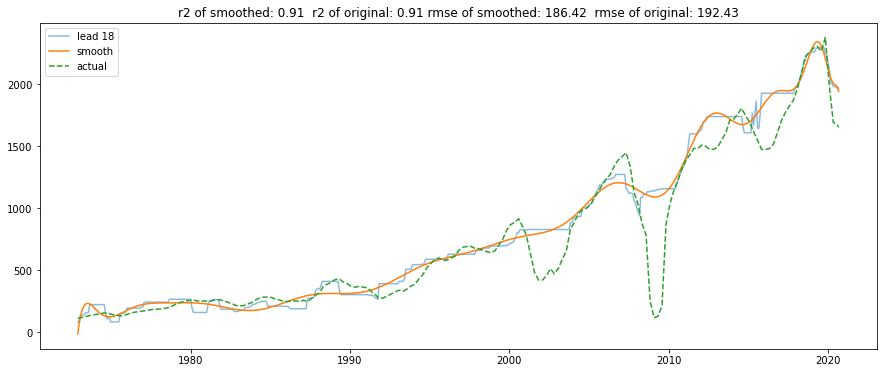

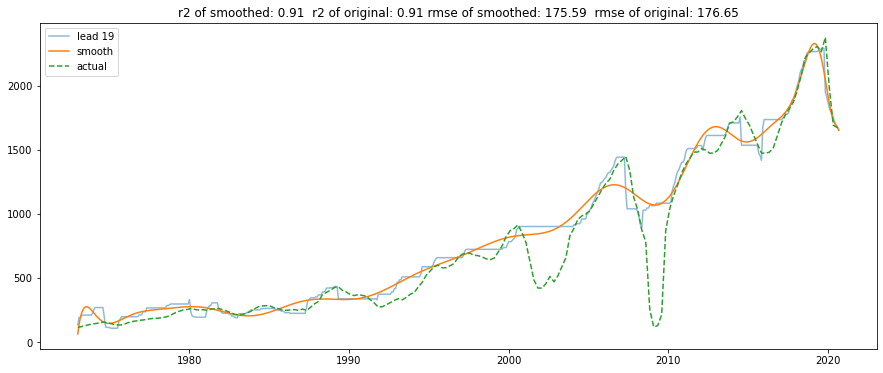

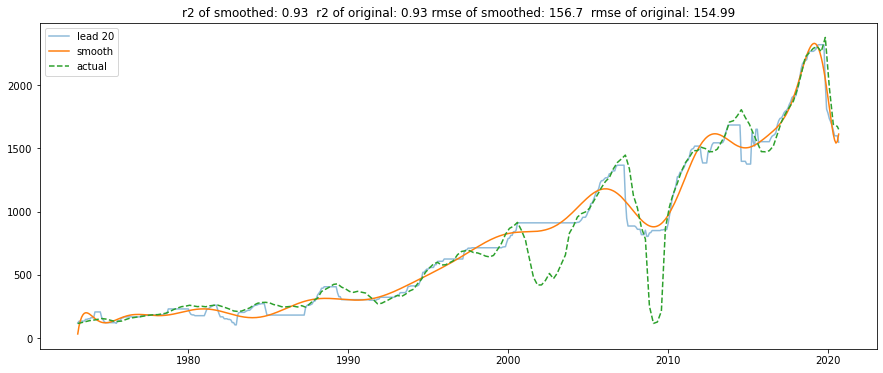

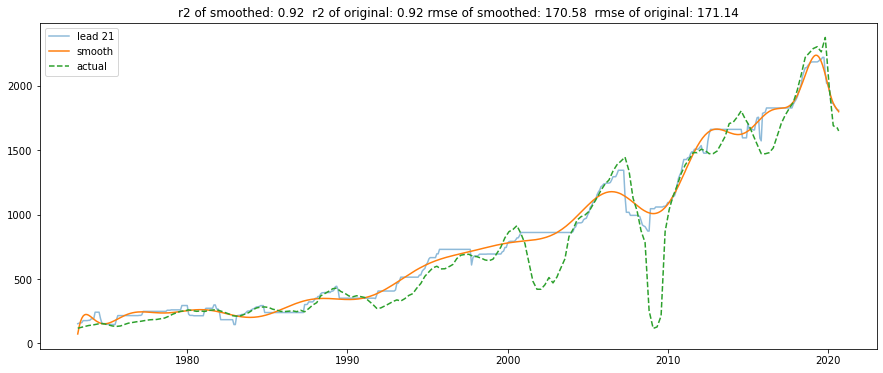

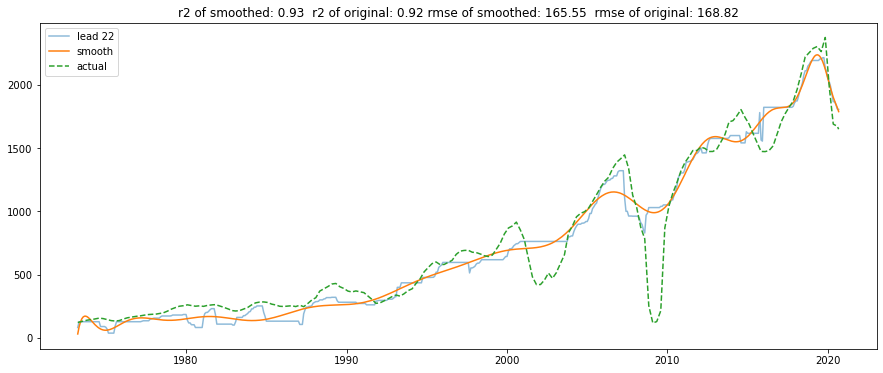

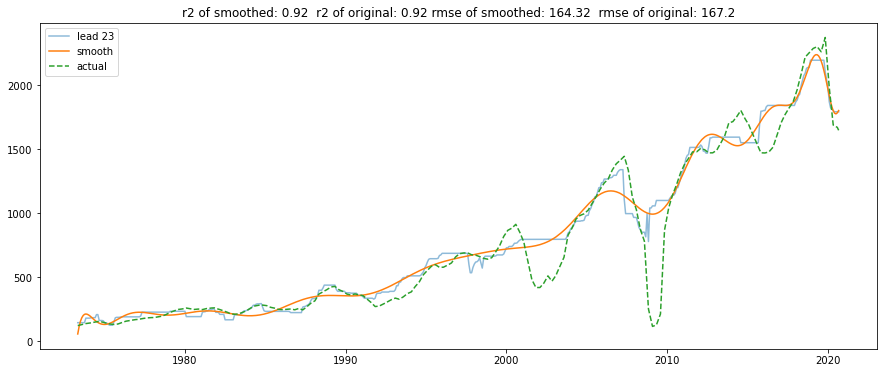

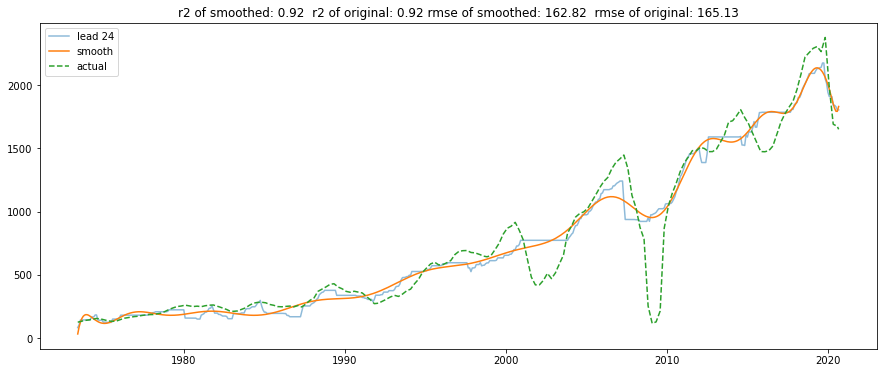

In [70]:
d = np.arange ('1971-07', '2020-10', np.timedelta64 (1,'M'), dtype='datetime64')
d = d.astype('datetime64[D]') 

for i in range(len(leads)):

    poly_fun = np.polyfit(list(range(len(result_list[i]))), result_list[i], cnt_list[i]+20, rcond=None, full=False, w=None, cov=False)
    p = np.poly1d(poly_fun)
    smooth = p(list(range(len(result_list[i]))))

    r_square_s = r2_score(smooth, true_list[i])
    r_square_ori = r2_score(result_list[i], true_list[i])
    
    rmse_s = np.sqrt(mean_squared_error(smooth, true_list[i]))
    rmse_ori = np.sqrt(mean_squared_error(result_list[i], true_list[i]))

    s1 = "r2 of smoothed: "+ str(np.round(r_square_s, 2)) + "  r2 of original: "+ str(np.round(r_square_ori, 2))
    s2 = "rmse of smoothed: "+ str(np.round(rmse_s, 2)) + "  rmse of original: "+ str(np.round(rmse_ori, 2))

    d_i = d[i:]

    plt.figure(figsize=(15, 6))

    plt.plot(d_i, result_list[i], label='lead ' + str(i+1), alpha=0.5)
    plt.plot(d_i, smooth, label='smooth')
    plt.plot(d_i, true_list[i], label='actual', linestyle='dashed')
    plt.title(s1 + " " + s2)
    plt.legend()
    plt.show()